In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # plotting library
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# libraries for displaying images
from IPython.display import Image
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [2]:
# read data file
df = pd.read_csv('mrt_lrt_data2.csv')
df.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [3]:
# Basic type information about data
df.dtypes

station_name     object
type             object
lat             float64
lng             float64
dtype: object

In [4]:
#check number of LRT and MRT stations
df_group = df.groupby('type').count()
df_group

,station_name,lat,lng
type,,,
LRT,38,38,38
MRT,119,119,119


In [5]:
#Get MRT data into new dataframe - confine analysis to MRT stations
df_MRT = df.loc[df['type'] == 'MRT']
df_MRT.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [6]:
# check size of MRT data
df_MRT.shape

(119, 4)

In [7]:
# create map of MRT stations using latitude and longitude values
latitude = 1.333207
longitude = 103.742308
map_stations = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(df_MRT['lat'], df_MRT['lng'], df_MRT['station_name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_stations)
map_stations

In [8]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P' # your Foursquare ID
CLIENT_SECRET = 'SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P
CLIENT_SECRET:SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB


In [9]:
#first station locaton 
df_MRT.loc[0, 'station_name']

'Jurong East'

In [10]:
#get latitude and longitude of Jurong East
station_latitude = df_MRT.loc[0, 'lat'] # station latitude value
station_longitude = df_MRT.loc[0, 'lng'] # station longitude value
station_name = df_MRT.loc[0, 'station_name'] # station name
print('Latitude and longitude values of {} are {}, {}.'.format(station_name, station_latitude, station_longitude))

Latitude and longitude values of Jurong East are 1.333207, 103.742308.


In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    station_latitude,
    station_longitude,
    radius,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P&client_secret=SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB&v=20180605&ll=1.333207,103.742308&radius=500&limit=100'

In [12]:
results = requests.get(url).json() #get results
results

{'meta': {'code': 200, 'requestId': '5e7a121514a126001b596036'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jurong East',
  'headerFullLocation': 'Jurong East, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 74,
  'suggestedBounds': {'ne': {'lat': 1.3377070045000046,
    'lng': 103.74680081871648},
   'sw': {'lat': 1.3287069954999955, 'lng': 103.73781518128351}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51c0356c498e19c820f5e48e',
       'name': 'UNIQLO',
       'location': {'address': '#02-37 & #03-30, Jem',
        'crossStreet': '50 Jurong Gateway Rd',
        'lat': 1.333175096970959,
        'lng': 103.74316037528905,
        'labeledLat

In [13]:
#define get_category_type function
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [15]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,UNIQLO,Clothing Store,1.333175,103.743160
1,MUJI 無印良品,Furniture / Home Store,1.333187,103.743064
2,Song Fa Bak Kut Teh 松發肉骨茶,Chinese Restaurant,1.333394,103.743420
3,Johan Paris,Bakery,1.334083,103.742384
4,The Rink,Skating Rink,1.333424,103.740345


In [16]:
#Map for regions
venues_map = folium.Map(location=[station_latitude, station_longitude], zoom_start=20)
# add a red circle marker to represent the Jurong East station
folium.features.CircleMarker(
    [station_latitude, station_longitude],
    radius=10,
    color='red',
    popup='Jurong East',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0])) # number of venues returned

74 venues were returned by Foursquare.


In [18]:
#create function to repeat same process
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station_Latitude', 
                  'Station_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    return(nearby_venues)

In [19]:
station_venues = getNearbyVenues(names=df_MRT['station_name'],
                                 latitudes=df_MRT['lat'], 
                                 longitudes=df_MRT['lng'])

Jurong East
Bukit Batok
Bukit Gombak
Choa Chu Kang
Yew Tee
Kranji
Marsiling
Woodlands
Admiralty
Sembawang
Yishun
Khatib
Yio Chu Kang
Ang Mo Kio
Bishan
Braddell
Toa Payoh
Novena
Newton
Orchard
Somerset
Dhoby Ghaut
City Hall
Raffles Place
Marina Bay
Marina South Pier
Tuas Link
Tuas West Road
Tuas Crescent
Gul Circle
Joo Koon
Pioneer
Boon Lay
Lakeside
Chinese Garden
Clementi
Dover
Buona Vista
Commonwealth
Queenstown
Redhill
Tiong Bahru
Outram Park
Tanjong Pagar
Bugis
Lavender
Kallang
Aljunied
Paya Lebar
Eunos
Kembangan
Bedok
Tanah Merah
Simei
Tampines
Pasir Ris
Expo
Changi Airport
HarbourFront
Chinatown
Clarke Quay
Little India
Farrer Park
Boon Keng
Potong Pasir
Woodleigh
Serangoon
Kovan
Hougang
Buangkok
Sengkang
Punggol
Bras Basah
Esplanade
Promenade
Nicoll Highway
Stadium
Mountbatten
Dakota
MacPherson
Tai Seng
Bartley
Lorong Chuan
Marymount
Caldecott
Botanic Gardens
Farrer Road
Holland Village
one-north
Kent Ridge
Haw Par Villa
Pasir Panjang
Labrador Park
Telok Blangah
Bayfront
Bukit Pa

In [20]:
#check size of station_venues
print(station_venues.shape)
station_venues.sample(10)

(4689, 7)


,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
3281,Stadium,1.302847,103.875417,Marble Slab Creamery,1.302638,103.873533,Ice Cream Shop
396,Bishan,1.350920,103.848206,The Coffee Bean & Tea Leaf,1.350424,103.848280,Café
1777,Lavender,1.307577,103.863155,新洽發食室,1.305616,103.863214,Coffee Shop
2810,Kovan,1.360207,103.885163,天外天潮洲鱼头炉 Tian Wai Tian Fish Head Steamboat,1.358404,103.884422,Asian Restaurant
2458,Chinatown,1.284566,103.843626,Burnt Ends,1.280502,103.841745,Australian Restaurant
4573,Geylang Bahru,1.321479,103.871457,Kallang Basin Swimming Complex,1.322641,103.872213,Pool
1471,Outram Park,1.280319,103.839459,The Populus Coffee & Food Co.,1.278215,103.840715,Café
1911,Paya Lebar,1.318214,103.893133,Swissbake,1.318631,103.892926,Bakery
2379,HarbourFront,1.265453,103.820514,Saigon Xpress,1.263764,103.821125,Vietnamese Restaurant
3723,Bayfront,1.281371,103.858998,Tower 1 Marina Bay Sands Hotel,1.282213,103.859881,Hotel


In [21]:
#find unique categories number
print('There are {} unique venue categories.'.format(len(station_venues['Venue_Category'].unique())))

There are 320 unique venue categories.


In [22]:
#find unique venue number
print('There are {} uniques venues.'.format(len(station_venues['Venue'].unique())))#number of unique venues

There are 3202 uniques venues.


In [23]:
station_venues.groupby('Station').count()

,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Station,,,,,,
Admiralty,9,9,9,9,9,9
Aljunied,50,50,50,50,50,50
Ang Mo Kio,40,40,40,40,40,40
Bartley,5,5,5,5,5,5
Bayfront,50,50,50,50,50,50
Beauty World,77,77,77,77,77,77
Bedok,55,55,55,55,55,55
Bedok North,22,22,22,22,22,22
Bedok Reservoir,7,7,7,7,7,7


In [24]:
# one hot encoding
station_onehot = pd.get_dummies(station_venues[['Venue_Category']], prefix="", prefix_sep="")
# add station column back to dataframe
station_onehot['Station'] = station_venues['Station']
# move station column to the first column
fixed_columns = [station_onehot.columns[-1]] + list(station_onehot.columns[:-1])
station_onehot = station_onehot[fixed_columns]
station_onehot.head()

,Station,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#size of new one-hot dataframe
station_onehot.shape

(4689, 321)

In [26]:
#group rows by station and by taking the mean of the frequency of occurrence of each category
station_grouped = station_onehot.groupby('Station').mean().reset_index()
station_grouped

,Station,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Admiralty,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,Aljunied,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,Ang Mo Kio,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,Bartley,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,Bayfront,0.0,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,...,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,Beauty World,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,Bedok,0.0,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.018182,0.000000,0.000000,0.000000
7,Bedok North,0.0,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,Bedok Reservoir,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
9,Bencoolen,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.02,0.010000,...,0.000000,0.000000,0.000000,0.020000,0.000000,0.0,0.000000,0.000000,0.020000,0.000000


In [27]:
#get size
station_grouped.shape

(118, 321)

In [28]:
#print each station along with the top 5 most common venues
num_top_venues = 5
for stn in station_grouped['Station']:
    print("----"+stn+"----")
    temp = station_grouped[station_grouped['Station'] == stn].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Admiralty----
         venue  freq
0  Supermarket  0.22
1   Food Court  0.11
2         Park  0.11
3  Bus Station  0.11
4   Food Truck  0.11


----Aljunied----
                           venue  freq
0             Chinese Restaurant  0.16
1                   Noodle House  0.12
2               Asian Restaurant  0.08
3  Vegetarian / Vegan Restaurant  0.06
4             Dim Sum Restaurant  0.04


----Ang Mo Kio----
             venue  freq
0      Coffee Shop  0.12
1       Food Court  0.08
2     Dessert Shop  0.08
3      Supermarket  0.05
4  Bubble Tea Shop  0.05


----Bartley----
             venue  freq
0     Noodle House   0.4
1             Café   0.2
2    Metro Station   0.2
3             Pool   0.2
4  Other Nightlife   0.0


----Bayfront----
        venue  freq
0       Hotel  0.08
1    Boutique  0.06
2  Waterfront  0.04
3     Theater  0.04
4    Tea Room  0.04


----Beauty World----
                venue  freq
0  Chinese Restaurant  0.10
1                Café  0.09
2   Korean Restaur

                 venue  freq
0    Electronics Store  0.25
1        Train Station  0.25
2                 Park  0.25
3          Coffee Shop  0.25
4  Peruvian Restaurant  0.00


----HarbourFront----
                 venue  freq
0   Chinese Restaurant  0.07
1  Japanese Restaurant  0.06
2     Toy / Game Store  0.04
3       Clothing Store  0.04
4          Coffee Shop  0.04


----Haw Par Villa----
                venue  freq
0  Miscellaneous Shop  0.11
1    Asian Restaurant  0.11
2          Food Court  0.11
3          Theme Park  0.11
4       Metro Station  0.11


----Hillview----
           venue  freq
0           Café  0.14
1    Supermarket  0.07
2            Gym  0.07
3  Shopping Mall  0.07
4    Coffee Shop  0.07


----Holland Village----
                venue  freq
0              Bakery  0.10
1      Ice Cream Shop  0.07
2                 Bar  0.07
3  Italian Restaurant  0.05
4      Cosmetics Shop  0.05


----Hougang----
                  venue  freq
0                  Café  0.08
1  Fast 

                venue  freq
0         Coffee Shop  0.10
1      Clothing Store  0.07
2  Chinese Restaurant  0.07
3   Korean Restaurant  0.05
4    Asian Restaurant  0.05


----Simei----
                 venue  freq
0  Japanese Restaurant  0.10
1          Coffee Shop  0.10
2   Chinese Restaurant  0.10
3            Juice Bar  0.05
4               Bakery  0.05


----Sixth Avenue----
               venue  freq
0             Bakery  0.08
1  Indian Restaurant  0.08
2           Wine Bar  0.06
3          BBQ Joint  0.06
4         Food Court  0.06


----Somerset----
                 venue  freq
0                Hotel  0.07
1        Shopping Mall  0.07
2  Japanese Restaurant  0.06
3       Clothing Store  0.05
4       Ice Cream Shop  0.03


----Stadium----
            venue  freq
0            Café  0.07
1         Stadium  0.07
2      Soup Place  0.04
3  Clothing Store  0.04
4     Coffee Shop  0.04


----Stevens----
                 venue  freq
0                 Café   0.2
1                Diner   0

In [29]:
#Sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
station_venues_sorted = pd.DataFrame(columns=columns)
station_venues_sorted['Station'] = station_grouped['Station']
for ind in np.arange(station_grouped.shape[0]):
    station_venues_sorted.iloc[ind, 1:] = return_most_common_venues(station_grouped.iloc[ind, :], num_top_venues)
station_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Supermarket,Food Truck,Snack Place,Park,Bus Station,Food Court,Asian Restaurant,Coffee Shop,Flea Market,Flower Shop
1,Aljunied,Chinese Restaurant,Noodle House,Asian Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Coffee Shop,Bus Station,Food Court,Seafood Restaurant,Breakfast Spot
2,Ang Mo Kio,Coffee Shop,Dessert Shop,Food Court,Japanese Restaurant,Supermarket,Bubble Tea Shop,Snack Place,Miscellaneous Shop,Modern European Restaurant,Sushi Restaurant
3,Bartley,Noodle House,Metro Station,Café,Pool,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court,Food Service
4,Bayfront,Hotel,Boutique,Tea Room,Lounge,Bar,Italian Restaurant,Waterfront,Bridge,Japanese Restaurant,Theater


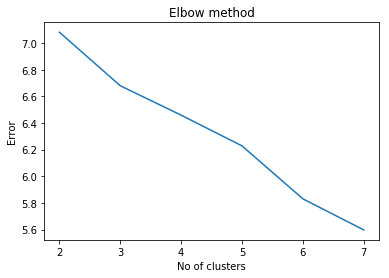

In [32]:
station_grouped_clustering = station_grouped.drop('Station', 1)
Error =[]
for i in range(2, 8):
    kmeans = KMeans(n_clusters = i).fit(station_grouped_clustering)
    kmeans.fit(station_grouped_clustering)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(2, 8), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [33]:
# set number of clusters
kclusters = 6
station_grouped_clustering = station_grouped.drop('Station', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(station_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 0, 1, 4, 4, 1, 1, 1, 4, 4])

In [34]:
# add clustering labels
station_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
station_merged = df_MRT
# merge station_grouped with station_data to add latitude/longitude for each station
station_merged = station_merged.join(station_venues_sorted.set_index('Station'), on='station_name')
station_merged.head() # check dataframe

,station_name,type,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jurong East,MRT,1.333207,103.742308,1.0,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Food Court,Shopping Mall,Sushi Restaurant,Steakhouse,Korean Restaurant,Clothing Store,Bakery
1,Bukit Batok,MRT,1.349069,103.749596,1.0,Coffee Shop,Chinese Restaurant,Food Court,Fast Food Restaurant,Grocery Store,Sandwich Place,Bookstore,Bowling Alley,Shopping Mall,Multiplex
2,Bukit Gombak,MRT,1.359043,103.751863,5.0,Food Court,Convenience Store,Stadium,Vegetarian / Vegan Restaurant,Steakhouse,Supermarket,Flea Market,Chinese Restaurant,Fast Food Restaurant,Malay Restaurant
3,Choa Chu Kang,MRT,1.385417,103.744316,5.0,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Bubble Tea Shop,Food Court,Supermarket,Sushi Restaurant,Shop & Service,Metro Station,Thai Restaurant
4,Yew Tee,MRT,1.397383,103.747523,1.0,Fast Food Restaurant,Japanese Restaurant,Diner,Pool,Food Court,Shopping Mall,Café,Sandwich Place,Yunnan Restaurant,Food Service


In [37]:
station_merged.isnull()

,station_name,type,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [39]:
station_merged.dropna(inplace=True)
station_merged.isnull()

,station_name,type,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [40]:
#cast cluster labels as integer for map
station_merged['Cluster Labels'] = station_merged['Cluster Labels'].astype(int)

In [42]:
#visualise results
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(station_merged['lat'], station_merged['lng'], station_merged['station_name'], station_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster - 1],
    fill=True,
    fill_color=rainbow[cluster - 1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters


In [43]:
#Examine the clusters - cluster 1
station_merged.loc[station_merged['Cluster Labels'] == 0, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Yio Chu Kang,Chinese Restaurant,Food Court,Noodle House,Café,Seafood Restaurant,Fast Food Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Tennis Court,College Auditorium
15,Braddell,Noodle House,Food Court,Chinese Restaurant,Café,Bakery,Hakka Restaurant,Thai Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant
18,Newton,Chinese Restaurant,Seafood Restaurant,Hotel Bar,Japanese Restaurant,Convenience Store,Café,Food Court,Grocery Store,Gym / Fitness Center,Thai Restaurant
26,Tuas Link,Harbor / Marina,Train Station,Gastropub,Bus Station,Chinese Restaurant,Sporting Goods Shop,Sports Club,Discount Store,Dive Bar,Flower Shop
34,Chinese Garden,Chinese Restaurant,Coffee Shop,Café,Chinese Breakfast Place,Residential Building (Apartment / Condo),Indian Restaurant,Asian Restaurant,Train Station,Food Court,Food Service
38,Commonwealth,Coffee Shop,Noodle House,Asian Restaurant,Food Court,Bakery,Snack Place,Chinese Restaurant,Bus Station,Garden,Candy Store
39,Queenstown,Food Court,Noodle House,Chinese Restaurant,Italian Restaurant,Train Station,Stadium,Spa,Café,Seafood Restaurant,Pool
40,Redhill,Chinese Restaurant,Coffee Shop,Hainan Restaurant,Gym,Park,Pool,Convenience Store,Malay Restaurant,Asian Restaurant,Train Station
41,Tiong Bahru,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Café,Sushi Restaurant,Food Court,Bakery,Noodle House,Supermarket,Park
47,Aljunied,Chinese Restaurant,Noodle House,Asian Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Coffee Shop,Bus Station,Food Court,Seafood Restaurant,Breakfast Spot


In [44]:
#Examine the clusters - cluster 2
station_merged.loc[station_merged['Cluster Labels'] == 1, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jurong East,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Food Court,Shopping Mall,Sushi Restaurant,Steakhouse,Korean Restaurant,Clothing Store,Bakery
1,Bukit Batok,Coffee Shop,Chinese Restaurant,Food Court,Fast Food Restaurant,Grocery Store,Sandwich Place,Bookstore,Bowling Alley,Shopping Mall,Multiplex
4,Yew Tee,Fast Food Restaurant,Japanese Restaurant,Diner,Pool,Food Court,Shopping Mall,Café,Sandwich Place,Yunnan Restaurant,Food Service
7,Woodlands,Café,Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Frozen Yogurt Shop,Chinese Restaurant,Clothing Store,Asian Restaurant,Shopping Mall,Indian Restaurant
13,Ang Mo Kio,Coffee Shop,Dessert Shop,Food Court,Japanese Restaurant,Supermarket,Bubble Tea Shop,Snack Place,Miscellaneous Shop,Modern European Restaurant,Sushi Restaurant
14,Bishan,Food Court,Coffee Shop,Café,Ice Cream Shop,Japanese Restaurant,Bubble Tea Shop,Chinese Restaurant,Supermarket,Cosmetics Shop,Bookstore
16,Toa Payoh,Snack Place,Coffee Shop,Chinese Restaurant,Food Court,Dessert Shop,Grocery Store,Bookstore,Monument / Landmark,Park,Fast Food Restaurant
17,Novena,Café,Coffee Shop,Japanese Restaurant,Hotel,Italian Restaurant,Ramen Restaurant,Chinese Restaurant,Dessert Shop,Supermarket,Sporting Goods Shop
23,Raffles Place,Café,Japanese Restaurant,Coffee Shop,Cocktail Bar,Hotel,Chinese Restaurant,Gym / Fitness Center,Salad Place,Italian Restaurant,Modern European Restaurant
30,Joo Koon,Fast Food Restaurant,Movie Theater,Bus Station,Snack Place,Gym / Fitness Center,Go Kart Track,Shopping Mall,Bakery,Coffee Shop,Chinese Breakfast Place


In [45]:
#Examine the clusters - cluster 3
station_merged.loc[station_merged['Cluster Labels'] == 2, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Little India,Indian Restaurant,Vegetarian / Vegan Restaurant,Music Venue,Playground,Food,Motel,Coffee Shop,Bakery,Museum,Hospital


In [46]:
#Examine the clusters - cluster 4
station_merged.loc[station_merged['Cluster Labels'] == 3, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
84,Caldecott,Flower Shop,Metro Station,Garden Center,Office,Ice Cream Shop,Café,Food Stand,Fish & Chips Shop,Flea Market,Food


In [47]:
#Examine the clusters - cluster 5
station_merged.loc[station_merged['Cluster Labels'] == 4, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Kranji,Stadium,Bakery,Dessert Shop,Bus Stop,Bus Line,Noodle House,Go Kart Track,Racetrack,Hotel Pool,Fast Food Restaurant
10,Yishun,Chinese Restaurant,Food Court,Fried Chicken Joint,Supermarket,Italian Restaurant,Coffee Shop,Hainan Restaurant,Jewelry Store,Bookstore,Mexican Restaurant
19,Orchard,Boutique,Sushi Restaurant,Shopping Mall,Hotel,Chinese Restaurant,Bakery,Cosmetics Shop,Coffee Shop,Bubble Tea Shop,Café
20,Somerset,Hotel,Shopping Mall,Japanese Restaurant,Clothing Store,Chinese Restaurant,Café,Ice Cream Shop,Coffee Shop,Boutique,Spa
21,Dhoby Ghaut,Café,Hotel,Park,Japanese Restaurant,Karaoke Bar,Restaurant,Movie Theater,Dessert Shop,Cosmetics Shop,Gift Shop
22,City Hall,Hotel,Café,Cocktail Bar,Lounge,Shopping Mall,French Restaurant,Japanese Restaurant,Coffee Shop,Bakery,Bookstore
24,Marina Bay,Pub,Building,Chinese Restaurant,Gym,Government Building,Sushi Restaurant,Brewery,Gastropub,Museum,Spanish Restaurant
25,Marina South Pier,Boat or Ferry,Pier,Metro Station,Seafood Restaurant,History Museum,Mexican Restaurant,Frozen Yogurt Shop,Food,Filipino Restaurant,Fish & Chips Shop
28,Tuas Crescent,Cafeteria,Train Station,Ski Area,Food Truck,Harbor / Marina,Food Service,Fish & Chips Shop,Flea Market,Flower Shop,Food
31,Pioneer,Bus Station,Japanese Restaurant,Supermarket,Seafood Restaurant,Fast Food Restaurant,Basketball Court,Shopping Mall,Bakery,Food Court,Gym


In [48]:
#Examine the clusters - cluster 6
station_merged.loc[station_merged['Cluster Labels'] == 5, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bukit Gombak,Food Court,Convenience Store,Stadium,Vegetarian / Vegan Restaurant,Steakhouse,Supermarket,Flea Market,Chinese Restaurant,Fast Food Restaurant,Malay Restaurant
3,Choa Chu Kang,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Bubble Tea Shop,Food Court,Supermarket,Sushi Restaurant,Shop & Service,Metro Station,Thai Restaurant
6,Marsiling,Food Court,Grocery Store,Steakhouse,Fast Food Restaurant,Japanese Restaurant,Bus Station,Asian Restaurant,Track,Hainan Restaurant,Trail
8,Admiralty,Supermarket,Food Truck,Snack Place,Park,Bus Station,Food Court,Asian Restaurant,Coffee Shop,Flea Market,Flower Shop
9,Sembawang,Coffee Shop,Convenience Store,Electronics Store,Asian Restaurant,Supermarket,Fast Food Restaurant,Bus Station,Japanese Restaurant,Bistro,Shopping Mall
11,Khatib,Coffee Shop,Bus Stop,Supermarket,Asian Restaurant,Bakery,Park,Train Station,Café,Skate Park,Shopping Mall
29,Gul Circle,Park,Train Station,Electronics Store,Coffee Shop,Yunnan Restaurant,Filipino Restaurant,Flea Market,Flower Shop,Food,Food Court
33,Lakeside,Coffee Shop,Convenience Store,Trail,Pool,Snack Place,Food Court,Yunnan Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
36,Dover,Fast Food Restaurant,Sandwich Place,College Cafeteria,Coffee Shop,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court
55,Pasir Ris,Food Court,Fast Food Restaurant,Convenience Store,Pharmacy,Sandwich Place,Coffee Shop,Diner,Sushi Restaurant,Italian Restaurant,Park


In [49]:
#group by station and find number of venue category of each type
stn_grp = station_venues.groupby(['Station', 'Venue_Category']).size()
stn_grp

Station    Venue_Category               
Admiralty  Asian Restaurant                 1
           Bus Station                      1
           Coffee Shop                      1
           Food Court                       1
           Food Truck                       1
           Park                             1
           Snack Place                      1
           Supermarket                      2
Aljunied   Asian Restaurant                 4
           BBQ Joint                        1
           Badminton Court                  1
           Basketball Court                 1
           Boarding House                   1
           Breakfast Spot                   1
           Bus Station                      2
           Café                             1
           Chinese Restaurant               8
           Coffee Shop                      2
           Convenience Store                1
           Cosmetics Shop                   1
           Dim Sum Restaurant          

In [50]:
#find station with max number of venue category
stn_grp.idxmax()

('Jalan Besar', 'Indian Restaurant')

In [51]:
# which indian restaurants
station_venues.query('Station == ["Jalan Besar"] and Venue_Category == ["Indian Restaurant"]')

,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
4459,Jalan Besar,1.305551,103.855443,Bismillah Biryani,1.304956,103.853602,Indian Restaurant
4465,Jalan Besar,1.305551,103.855443,Murugan Idli Shop,1.308842,103.856380,Indian Restaurant
4472,Jalan Besar,1.305551,103.855443,Azmi Restaurant,1.308256,103.853075,Indian Restaurant
4473,Jalan Besar,1.305551,103.855443,Sakunthala's Restaurant,1.306000,103.852169,Indian Restaurant
4479,Jalan Besar,1.305551,103.855443,Komala Vilas (Buffalo Rd),1.306308,103.851158,Indian Restaurant
4482,Jalan Besar,1.305551,103.855443,Khansama Tandoori Restaurant,1.308251,103.853122,Indian Restaurant
4492,Jalan Besar,1.305551,103.855443,Kailash Parbat,1.308039,103.852660,Indian Restaurant
4493,Jalan Besar,1.305551,103.855443,Lagnaa Barefoot Dining,1.306472,103.852298,Indian Restaurant
4501,Jalan Besar,1.305551,103.855443,Veeras Curry Restaurant @ Hindoo Rd,1.308650,103.853515,Indian Restaurant
4505,Jalan Besar,1.305551,103.855443,Sakunthala's Restaurant,1.309475,103.855717,Indian Restaurant


In [52]:
A = stn_grp.to_frame() # convert series object to dataframe for further analysis
A['Counts'] = A.iloc[:,-1] #rename counts as Counts column
A.head()
A=A.drop([A.columns[-2]], axis = 'columns') # remove duplicate count column
A.head()

Counts
Station   Venue_Category          
Admiralty Asian Restaurant       1
          Bus Station            1
          Coffee Shop            1
          Food Court             1
          Food Truck             1

In [53]:
Alist = A.groupby('Venue_Category')['Counts'].sum() #Sum up number for each venue category
Alist

Venue_Category
ATM                                1
Accessories Store                  4
Airport                            2
Airport Lounge                     5
American Restaurant               22
Arcade                             4
Art Gallery                       21
Art Museum                         2
Arts & Crafts Store                8
Asian Restaurant                 122
Athletics & Sports                 2
Australian Restaurant              5
BBQ Joint                         42
Baby Store                         1
Badminton Court                    1
Bagel Shop                         2
Bakery                           120
Bank                               2
Bar                               43
Basketball Court                   7
Bay                                1
Bed & Breakfast                    5
Beer Bar                          16
Beer Garden                        8
Beer Store                         1
Betting Shop                       1
Bike Rental / Bike Shar

In [54]:
Alist.sort_values(ascending = False, inplace = True) #sort venue category in descending order
Top_10 = Alist.head(10) #find top 10 venue category
Top_10

Venue_Category
Coffee Shop             237
Chinese Restaurant      237
Café                    227
Japanese Restaurant     181
Food Court              179
Hotel                   133
Asian Restaurant        122
Bakery                  120
Indian Restaurant       114
Fast Food Restaurant     99
Name: Counts, dtype: int64

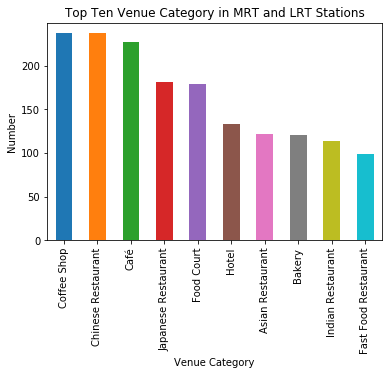

In [55]:
# plot Bar graph
import matplotlib as mpl
import matplotlib.pyplot as plt

Top_10.plot(kind = 'bar')

plt.title('Top Ten Venue Category in MRT and LRT Stations')
plt.xlabel('Venue Category')
plt.ylabel('Number')
plt.show()

In [56]:
#group by station and find number of venue of each type
stn_grp2 = station_venues.groupby(['Station', 'Venue']).size()
stn_grp2

Station    Venue                                         
Admiralty  Ajmir Store Pte Ltd                               1
           Bus Stop 46789                                    1
           Circle Green Park                                 1
           Kampung Admiralty Hawker Centre                   1
           Mr Bean                                           1
           NTUC FairPrice                                    1
           NTUC Fairprice                                    1
           Starbucks                                         1
           家传小吃                                              1
Aljunied   7-Eleven                                          1
           Aikido Shinju-kai (Singapore) HQ 心柔会本部道场          1
           Aljunied MRT Station (EW9)                        1
           Builders At Sims                                  1
           Bus Stop 80231 (Blk 59)                           1
           Bus Stop 80239 (opp Blk 59)                      

In [57]:
stn_grp2.idxmax() #Find venue with max number and the corresponding station

('Downtown', 'Starbucks')

In [58]:
#detailed analysis on Downtown Starbucks -get new df containing all Starbucks outlets at Downtown Station
Downtown_df = station_venues.loc[(station_venues['Station']=='Downtown') & (station_venues['Venue']=='Starbucks'),['Station', 'Station_Latitude', 'Station_Longitude','Venue','Venue_Latitude', 'Venue_Longitude' ]] 
Downtown_df

,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude
4080,Downtown,1.27949,103.852802,Starbucks,1.279335,103.854128
4112,Downtown,1.27949,103.852802,Starbucks,1.277949,103.850985
4131,Downtown,1.27949,103.852802,Starbucks,1.276988,103.852458
4146,Downtown,1.27949,103.852802,Starbucks,1.279422,103.854494


In [59]:
#Plot locations of these Starbucks
#display map with locations of subway
#get downtown latitude, longitude

d_latitude = 1.27949 # station latitude value
d_longitude = 103.852802 # station longitude value

#display map centered on downtown station
downtown_map = folium.Map(location=[d_latitude, d_longitude], zoom_start=17)

#add circle marker on Admiralty station
folium.features.CircleMarker(
    [d_latitude, d_longitude],
    radius=10,
    popup='Downtown',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(downtown_map)

for lat, lng, label in zip(Downtown_df.Venue_Latitude, Downtown_df.Venue_Longitude, Downtown_df.Venue):
    folium.features.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    fill=True,
    color='blue',
    fill_color='blue',
    fill_opacity=0.6
    ).add_to(downtown_map)
    
# display map
downtown_map

In [60]:
#find atm locations
ATM_df = station_venues.loc[(station_venues['Venue_Category']=='ATM'),['Station', 'Station_Latitude', 'Station_Longitude','Venue_Category', 'Venue','Venue_Latitude', 'Venue_Longitude' ]]
ATM_df

,Station,Station_Latitude,Station_Longitude,Venue_Category,Venue,Venue_Latitude,Venue_Longitude
2942,Punggol,1.405191,103.902367,ATM,POSB AutoLobby,1.405983,103.901544


In [ ]:
#End